In [2]:
from datetime import datetime
import tensorflow as tf
import importlib
import numpy as np
import importlib
import pandas as pd



In [3]:
# import config 
import configs.config
importlib.reload(configs.config)
from configs.config import CFG
from utils import config
config = config.Config.from_json(CFG)

In [4]:
import matplotlib.pyplot as plt 

def plot_all (array):
    plt.figure(figsize=(15,5))
    array_len = int(array.shape[-1])
    for i in range(array_len):
        plt.subplot(array_len,1,i+1)
        plt.plot(array[:,i])


## Create Dataset

In [5]:
# create Train Series and Dataset 
import dataloader.dataloader_v3
importlib.reload(dataloader.dataloader_v3)
from dataloader.dataloader_v3 import Series,Dataset
try: 
    del ds
except:
    pass
from dataloader.dataloader_v3 import Test_Series, Train_Series
try: 
    del test_series , train_series
except:
    pass

train_series = Train_Series(config.data,config.paths)
train_series.createSeries()
test_series = Test_Series(config.data,config.paths)
test_series.createSeries()

In [5]:
# serie_id = train_series.series_ids[1]
# serie = train_series.series[serie_id]
# # plot_all(serie.serie)
# plot_all(serie.mask)
# plot_all(serie.slices)

In [6]:
%load_ext autoreload
%autoreload 2 

from dataloader.dataloader_v3 import Dataset


ds = Dataset(train_series,test_series, normalize=True,positional_encoding=True,outputs_no=-3)
ds.make_dataset()
windowed_train_ds = ds.get_windowed_trainset(17280//3,32,64)

In [7]:
# window_size = 17280//3
# batch_size = 32
# shuffle_buffer = 64
# num_classes = np.max(ds.ds_train[:,-1])+1
# outputs_no = -3
# print(num_classes)
# multi_class_range = np.max(ds.ds_train[:,-2]+1)
# print(multi_class_range)
# ds.ds_train.shape
# dataset = tf.data.Dataset.from_tensor_slices(ds.ds_train)
# dataset = dataset.window(window_size, shift=window_size, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(window_size))
# dataset = dataset.map(lambda window: (window[:,:outputs_no], 
#                                             tf.one_hot(tf.dtypes.cast(window[:,-3],tf.int8),depth=multi_class_range),
#                                             tf.one_hot(tf.dtypes.cast(window[:,-2],tf.int8),depth=multi_class_range), 
#                                             tf.one_hot(tf.dtypes.cast(window[:,-1],tf.int8),depth=num_classes)
# ))


# # Shuffle the windows
# dataset = dataset.shuffle(shuffle_buffer)

# # Create batches of windows
# dataset = dataset.batch(batch_size).prefetch(1)

## Save Datset to Files 

In [8]:
# import pickle
# # Include the epoch in the file name (uses `str.format`)
# ds_path = "./model/saved_ds/ds.obj"

# with  open(ds_path,'wb') as file:
#     exampleObj = pickle.dump(ds,file)


In [9]:
# import dill
# ds_path = "./model/saved_ds/ds.pkl"
# with open(ds_path,'wb') as file:
#     my_pickle = dill.dump(ds,file)

## Save Test Series to Files 

In [10]:
# # Include the epoch in the file name (uses `str.format`)
# test_path = "./model/saved_ds/test_series.obj"

# with  open(test_path,'wb') as file:
#     exampleObj = pickle.dump(ds,file)

## Call model and compile

In [8]:
%load_ext autoreload
%autoreload 2 

from model.model_multi import Unet_Multi
try: 
    del unet
except:
    pass






unet = Unet_Multi(n_classes=3,multi_class_range=10,n_filters=32)
# unet.compile(optimizer='adam',
#               loss={
#                   "multi_awake" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                   "multi_sleep": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                   "sleep_awake" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               },

#               metrics=['accuracy'])
unet.model((17280//3,7)).summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5760, 7)]    0           []                               
                                                                                                  
 downsampling_block (Downsampli  ((None, 2880, 32),  3808        ['input_1[0][0]']                
 ngBlock)                        (None, 5760, 32))                                                
                                                                                                  
 downsampling_block_1 (Downsamp  ((None, 1440, 64),  18560       ['downsampling_block[0][0]']     
 lingBlock)                      (None, 2880, 64))                                                
      

## Train Model and save weights and model to files

In [9]:
# def apply_gradients(model,x,y1,y2,y3,losses):
#     with tf.GradientTape() as tape:
#         multi_awake, multi_sleep, sleep_awake = model(x)
#         loss1  = losses["multi_awake"](y_true = y1, y_pred = multi_awake, from_logits = True)
#         loss2 = losses["multi_sleep"](y_true = y2, y_pred = multi_sleep, from_logits = True)
#         loss3 = losses["sleep_awake"](y_true = y3, y_pred = sleep_awake, from_logits = True)
#     total_loss = np.mean(loss1*loss_weights["multi_awake"] +loss2*loss_weights["multi_sleep"] + loss3*loss_weights["sleep_awake"] )  
#     gradients = tape.gradient(total_loss,model.trainable_weights)                 
#     return loss1,loss2,loss3, total_loss

loss={
    "multi_awake" : tf.keras.losses.CategoricalCrossentropy(),
    "multi_sleep": tf.keras.losses.CategoricalCrossentropy(),
    "sleep_awake" : tf.keras.losses.CategoricalCrossentropy(),
}

loss_weights={
    "multi_awake": 0.33,
    "multi_sleep": 0.33,
    "sleep_awake" : 1.0
} 
optimizer = tf.keras.optimizers.Adam()

In [10]:
# for x,y1,y2,y3 in dataset:
#     print(x)
#     break

In [11]:
from datetime import datetime
#train model
@tf.function
def train():
    with tf.GradientTape() as tape:
        multi_awake, multi_sleep, sleep_awake = unet(x,training = True)
        loss1  = loss["multi_awake"](y1, multi_awake)
        loss2 = loss["multi_sleep"](y2, multi_sleep)
        loss3 = loss["sleep_awake"](y3, sleep_awake)
    total_loss = tf.math.reduce_mean(loss1*loss_weights["multi_awake"] +loss2*loss_weights["multi_sleep"] + loss3*loss_weights["sleep_awake"] )  
    gradients = tape.gradient([loss1,loss2,loss3],unet.trainable_weights)      
    optimizer.apply_gradients(zip(gradients,unet.trainable_weights))
    return loss1, loss2, loss3,total_loss


    # print(type(loss3.numpy()))
verbose = "Epoch {} Loss1: {} Loss2: {} Loss3: {}, Total loss: {}"
epochs = 2
for epoch in range(1,epochs+1):
    for x,y1,y2,y3 in windowed_train_ds:
        loss1, loss2, loss3,total_loss =  train()
        print(verbose.format(
        tf.keras.backend.get_value(epoch),
        tf.cast(loss1,tf.float32),
        tf.cast(loss2,tf.float32),
        tf.cast(loss3,tf.float32),
        tf.cast(total_loss,tf.float32),
        end ='\r'
        ))
    print(verbose.format(
        tf.keras.backend.get_value(epoch),
        tf.cast(loss1,tf.float32),
        tf.cast(loss2,tf.float32),
        tf.cast(loss3,tf.float32),
        tf.cast(total_loss,tf.float32),
    ))


Epoch 1 Loss1: 17.687814712524414 Loss2: 2.6751863956451416 Loss3: 16.185989379882812, Total loss: 22.905780792236328
Epoch 1 Loss1: 12.467850685119629 Loss2: 2.5306687355041504 Loss3: 10.806848526000977, Total loss: 15.756360054016113
Epoch 1 Loss1: 5.503607273101807 Loss2: 1.1913626194000244 Loss3: 8.27912712097168, Total loss: 10.4884672164917
Epoch 1 Loss1: 2.4222571849823 Loss2: 1.1541473865509033 Loss3: 5.209994316101074, Total loss: 6.390207767486572
Epoch 1 Loss1: 1.1295013427734375 Loss2: 1.1581628322601318 Loss3: 2.4653048515319824, Total loss: 3.220233917236328
Epoch 1 Loss1: 0.9999755024909973 Loss2: 1.206721544265747 Loss3: 2.841913938522339, Total loss: 3.5701241493225098
Epoch 1 Loss1: 0.996787965297699 Loss2: 1.1542880535125732 Loss3: 3.2736361026763916, Total loss: 3.9834911823272705
Epoch 1 Loss1: 0.9907511472702026 Loss2: 1.085757851600647 Loss3: 2.611025810241699, Total loss: 3.296273708343506
Epoch 1 Loss1: 0.9859198927879333 Loss2: 1.0361251831054688 Loss3: 1.6512

In [158]:
@tf.function
def prt():

    tf.print(verbose.format(
    tf.keras.backend.get_value(epoch),
    tf.cast(loss1,tf.float32),
    tf.cast(loss2,tf.float32),
    tf.cast(loss3,tf.float32),
    tf.cast(total_loss,tf.float32),
    ))
prt()

Epoch 1 Loss1: 0.23 Loss2: 0.26 Loss3: 0.25, Total loss: 0.41


In [115]:
for el in tf.range(1):
    print(tf.keras.backend.get_value(el)) 

0


In [168]:
c = tf.constant(0.0)

In [93]:
unet.trainable_weights

[<tf.Variable 'downsampling_block/double_conv1d/conv1d/kernel:0' shape=(3, 7, 32) dtype=float32, numpy=
 array([[[ 1.97262287e-01,  5.35069048e-01,  1.74062431e-01,
          -1.01213068e-01, -3.12748194e-01, -4.88504827e-01,
          -4.30460125e-01, -6.65335417e-01, -4.04082835e-01,
          -2.50678450e-01, -2.92067021e-01,  2.68129915e-01,
           5.26017904e-01, -1.88376635e-01,  7.13091671e-01,
          -1.39554501e-01, -1.53460830e-01,  4.31226909e-01,
           3.33553046e-01, -8.54749009e-02,  1.04421213e-01,
           3.96050289e-02,  4.09678131e-01, -4.40014362e-01,
          -7.55324587e-02, -3.63546640e-01, -2.53898144e-01,
          -4.54519153e-01,  1.68731689e-01, -9.17554796e-02,
           2.12101430e-01, -2.23378971e-01],
         [-4.24997509e-02,  1.90118015e-01,  2.95700520e-01,
          -5.00433624e-01,  2.81747758e-01, -4.02628988e-01,
          -7.94805214e-02,  6.46894649e-02, -2.51387265e-02,
          -2.53331304e-01, -2.88056105e-01,  3.19355607e-0

In [94]:
gradients

[<tf.Tensor: shape=(3, 7, 32), dtype=float32, numpy=
 array([[[-5.75830229e-04,  1.18998927e-03, -3.70114256e-04,
           4.26104991e-04, -4.82512871e-04, -7.06550665e-04,
          -1.50586409e-03, -5.40046487e-04,  7.18954470e-06,
          -4.59943432e-04,  1.65529113e-04,  5.64526650e-04,
           9.37023869e-05, -7.26308499e-04,  1.60055945e-03,
           2.19998765e-04,  4.13240166e-04, -1.16462674e-04,
           1.47338351e-03,  1.39556461e-04, -2.94039899e-04,
          -3.34721582e-04,  8.06424941e-04, -4.50336025e-04,
           7.77511508e-04, -1.60530838e-03,  7.92136416e-06,
          -2.35510350e-04,  4.79545415e-04, -2.77759536e-05,
          -3.30833136e-05, -1.21681707e-03],
         [ 8.47223215e-04, -1.64840110e-02, -1.02436036e-01,
          -3.39795724e-02, -1.29402634e-02,  2.52828989e-02,
          -2.64155790e-02,  5.54542430e-02, -7.37123750e-03,
           8.56176317e-01, -1.89068560e-02,  1.52964359e-02,
           1.55300926e-02, -2.30439961e-01, -1.3

In [88]:

print(verbose.format(
    epoch,
    loss1,
    loss2,
    loss3,
    total_loss
))

Epoch  1 Loss1: 0.227 Loss2: 0.259 Loss3: 0.252, Total loss: 0.413


In [12]:
windowed_test_ds = ds.get_windowed_testset(17280//3,32)

y_pred_test = unet.predict(windowed_test_ds)

(51840, 7)
<_TensorSliceDataset element_spec=TensorSpec(shape=(7,), dtype=tf.float64, name=None)>
1/1 [==============================] - 2s 2s/step


In [39]:
ds.test_slices_ids


[((0, 17279), '038441c925bb'),
 ((17280, 34559), '03d92c9f6f8a'),
 ((34560, 51839), '0402a003dae9')]

In [36]:
test_series.series["038441c925bb"].valid_ranges_padding

[[11160, 5971]]

In [44]:
y_pred_test[:][0]


array([[9.9748307e-01, 5.5486773e-04, 1.2629399e-03, ..., 5.8004679e-10,
        6.0854738e-10, 6.2655062e-08],
       [9.9965477e-01, 3.0019041e-04, 4.4086162e-05, ..., 3.9445199e-16,
        5.7226304e-15, 2.6464661e-10],
       [9.9999845e-01, 1.1601953e-06, 7.9933933e-08, ..., 4.2287189e-18,
        7.7911041e-19, 3.3171587e-11],
       ...,
       [9.9999976e-01, 7.8229050e-08, 3.2283953e-08, ..., 4.8628794e-22,
        7.0096728e-17, 9.2708137e-15],
       [9.9999964e-01, 3.4056594e-08, 7.9402334e-08, ..., 6.3012551e-20,
        4.6789388e-15, 4.3744823e-14],
       [9.9877304e-01, 1.2664872e-05, 2.6077196e-05, ..., 4.6459604e-11,
        8.0971381e-09, 3.8605421e-08]], dtype=float32)

In [214]:
print(test_series.series["038441c925bb"].valid_ranges_padding)
test_series.series["038441c925bb"].valid_ranges_table
print(test_series.series["038441c925bb"].valid_ranges_padding[0][0])
def calculate_start_stop(valid_range_padding, valid_ranges_table):
    start = valid_range_padding[0][0]
    stop = 0
    for i in range(len(valid_ranges_table)):
        if i == len(valid_ranges_table)-1:
            stop = stop + valid_range_padding[i][0] +  valid_ranges_table[i][1] - valid_ranges_table[i][0]
        else:
            stop = stop + valid_range_padding[i][0] + valid_range_padding[i][1] +  valid_ranges_table[i][1] - valid_ranges_table[i][0]
    return (start,stop)

print(calculate_start_stop(test_series.series["038441c925bb"].valid_ranges_padding,test_series.series["038441c925bb"].valid_ranges_table ))

[[11160, 5971]]
11160
(11160, 11309)


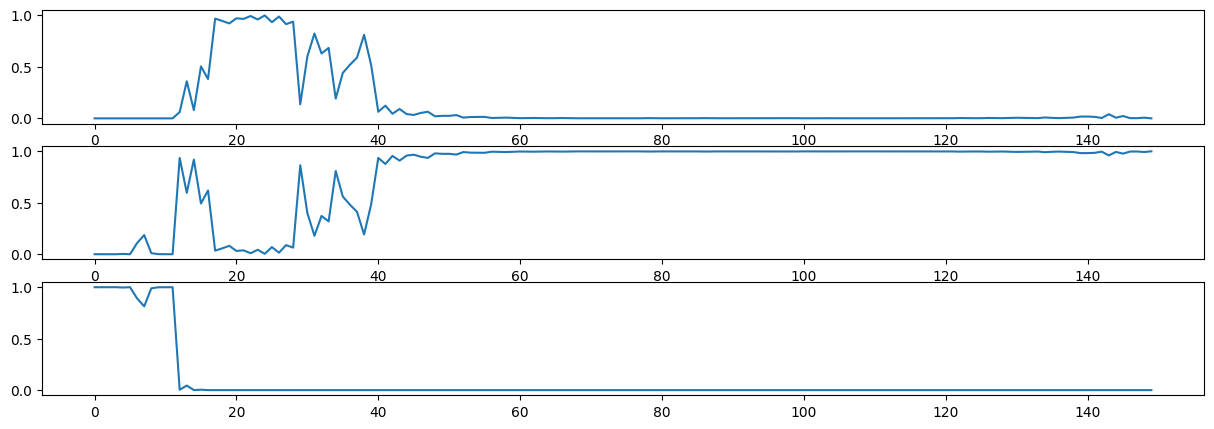

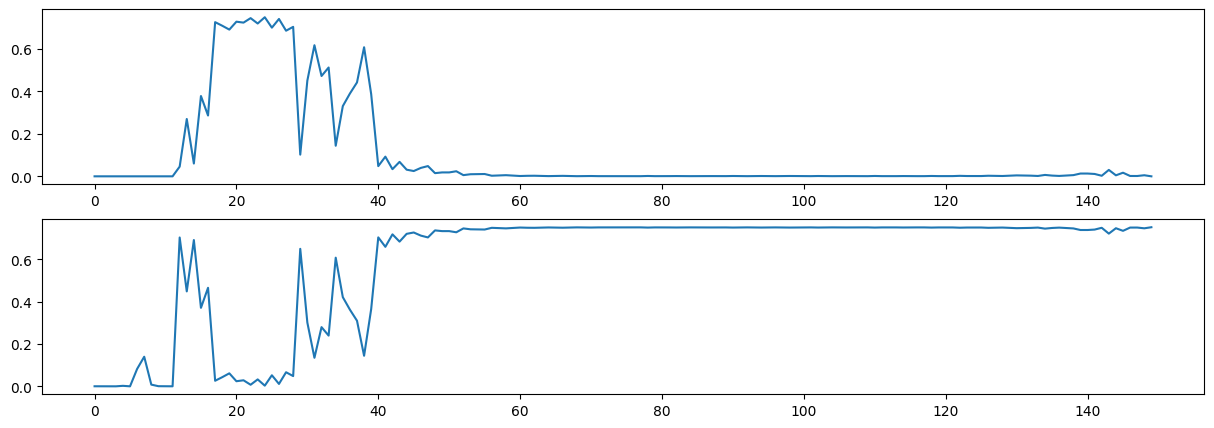

In [235]:
class Prediction():
    def __init__(self,  serie_id, valid_range,raw_prediction):
        self.serie_id = serie_id
        self.valid_range = valid_range
        self.raw_prediction = raw_prediction
        self.main_prediction = None
        self.auxiliary_predictions = []
    def separate(self):
        start, stop = self.valid_range
        all_predictions_no = len(self.raw_prediction)
        for i in range(all_predictions_no):
            outputs = self.raw_prediction[i].shape[-1]
            prediction = self.raw_prediction[i].reshape(-1,outputs)[start:stop+1]
            # get auxiliary predicitons
            if i  != all_predictions_no -1:
                self.auxiliary_predictions.append(prediction)
                # get main prediction 
            else: 
                self.main_prediction = prediction
    

    def create_events(self, loss_weights,only_top_score = True , generate_dummies = False):
        # create step seg list
        #         - events - segmentation mask
        #         -  score   - predicited vaues for chosen event

        def detectChange(last_val,current_val):
            if last_val == -1 or current_val == -1:
                return False

        scores_weights = list(loss_weights.values())
        all_predictions_no = len(self.raw_prediction)
        scores = np.zeros_like(self.main_prediction)
        plot_all(self.main_prediction)
        for i in range(all_predictions_no-1):
            
            # get auxiliary predicitons        
            outputs = self.auxiliary_predictions[i].shape[-1]
            outputs_weights = [i/(outputs-1) for i in range(outputs)]
            outputs_weights = np.expand_dims(np.array(outputs_weights),axis = -1)
            

            auxiliary_events = np.argmax(self.auxiliary_predictions[i],axis = -1,keepdims=True)
            # create onehot matrix with outputs weights  to make a list of output weights with the highest probability
            eye = np.zeros((auxiliary_events.shape[0],outputs_weights.shape[0]))
            eye[np.arange(auxiliary_events.shape[0]),auxiliary_events[:,0]] = 1
            max_prob_outputs_weights = np.where (auxiliary_events > 0, np.dot(eye,outputs_weights), 0)
            # multiply max score with specific output weight 
            auxiliary_score = np.max(self.auxiliary_predictions[i])*max_prob_outputs_weights.T * scores_weights[i]
            scores[:,i] = (self.main_prediction[:,i] + auxiliary_score)/(1.0 + scores_weights[i])
               
        scores  = scores[:,:2] # only wakeup and onset to consider
        plot_all(scores)
        events = np.argmax(scores,axis = -1,keepdims=True)
        scores = np.max(scores,axis=-1,keepdims=True) 

        return events,scores 


serie_id = "038441c925bb"        
valid_range = calculate_start_stop(test_series.series[serie_id].valid_ranges_padding,test_series.series[serie_id].valid_ranges_table )
raw_prediction = y_pred_test[:][:3]

try:
    del test_prediction
except:
    pass

test_prediction = Prediction(serie_id,valid_range,raw_prediction)
test_prediction.separate()
events,scores = test_prediction.create_events(loss_weights)

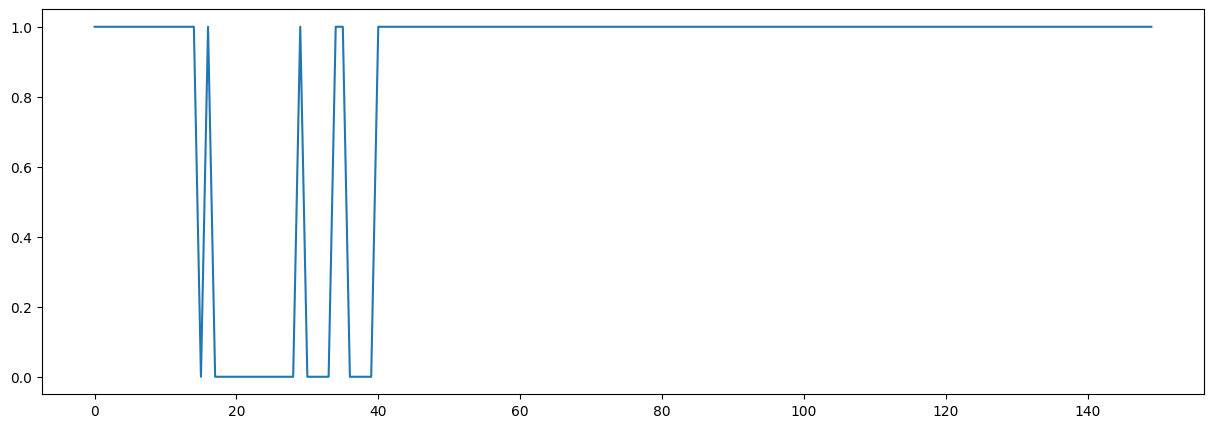

In [237]:
plot_all(events)

In [201]:
windowed_traintest_ds = ds.windowed_testset(ds.train[:,:-3],17280//3,32)
y_pred_train = unet.predict(windowed_traintest_ds)

(14653440, 7)
<_TensorSliceDataset element_spec=TensorSpec(shape=(7,), dtype=tf.float64, name=None)>
80/80 [==============================] - 64s 791ms/step


(0, 207359)


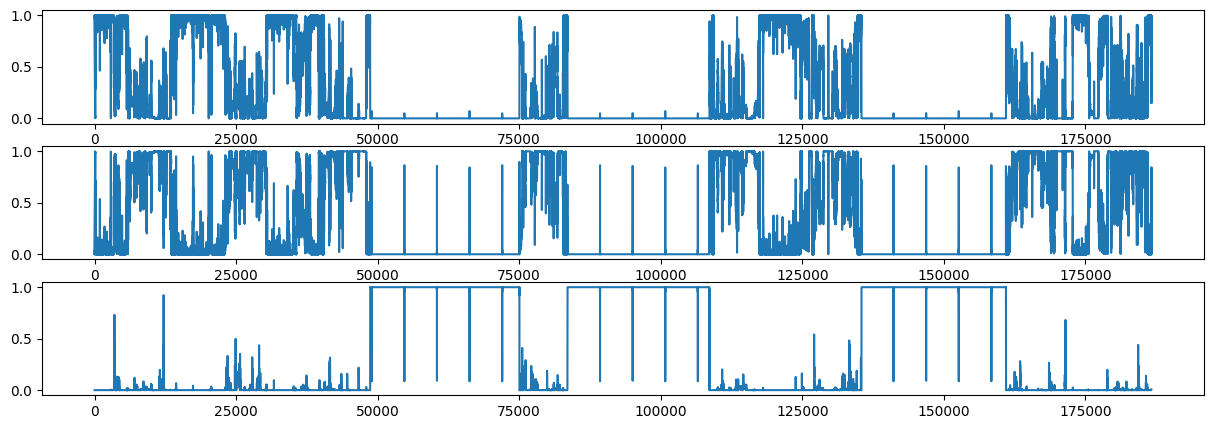

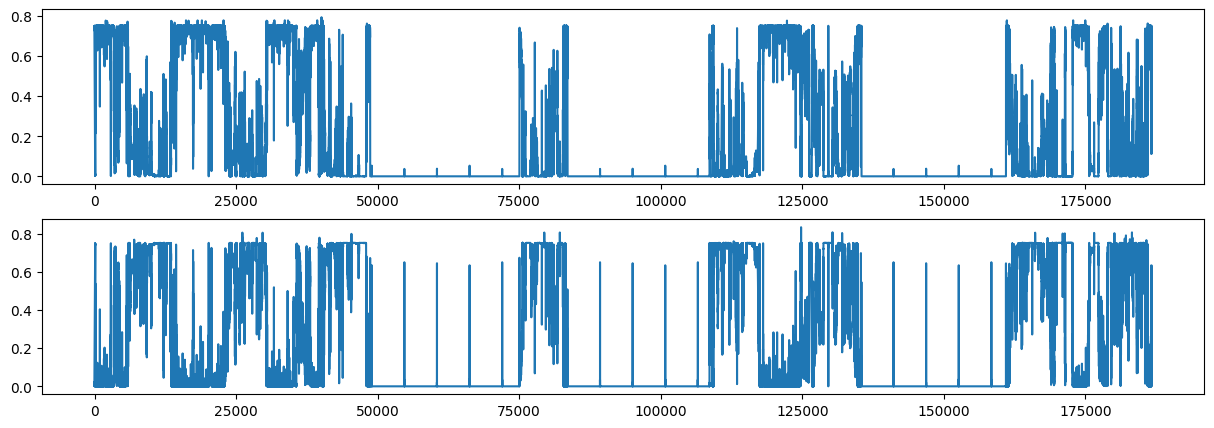

In [242]:
train_serie_id = list(train_series.series.keys())[0]
train_valid_range =calculate_start_stop(train_series.series[train_serie_id].valid_ranges_padding,train_series.series[train_serie_id].valid_ranges_table )

window_size = 17280//3
for slice_range,serie_id in ds.slices_ids:
    if train_serie_id == serie_id:
        print(slice_range)
        break

window_start = slice_range[0]//window_size
window_stop =  (slice_range[1]- slice_range[0] + 1 )//window_size
raw_prediction  = y_pred_train[:][window_start:window_stop]


try:
    del train_prediction
except:
    pass

train_prediction = Prediction(train_serie_id,train_valid_range,raw_prediction)
train_prediction.separate()
events,scores = train_prediction.create_events(loss_weights)

## POST PROCESSING TECHNIQUES

#### Smoothing

<Axes: >

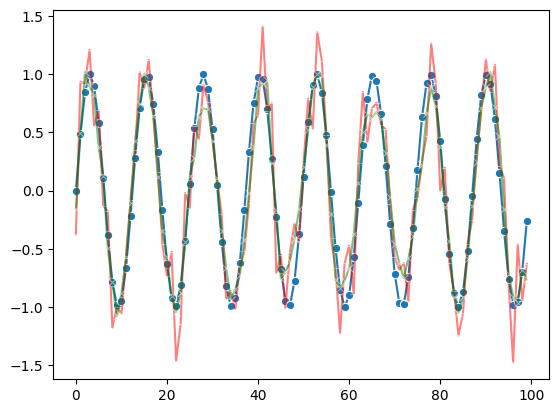

In [241]:
from scipy.signal import savgol_filter
import seaborn as sns
num_points = 100
x = np.linspace(0,50,num_points)
y = np.sin(x)
noise = 1*np.random.random(size = num_points)- 0.5

sns.lineplot(y,marker = 'o') 
sns.lineplot(y+noise,marker = '_', color = 'red', alpha = 0.5)
sns.lineplot(savgol_filter(y+noise,window_length=3,polyorder=1), marker = 'x',color = 'green', alpha = 0.5)


In [289]:
train_series.series[train_serie_id].slices[:,-1]

array([2., 2., 2., ..., 2., 2., 2.])

In [275]:
events[events ==1] and  savgol_filter_events[savgol_filter_events > 0.5]

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

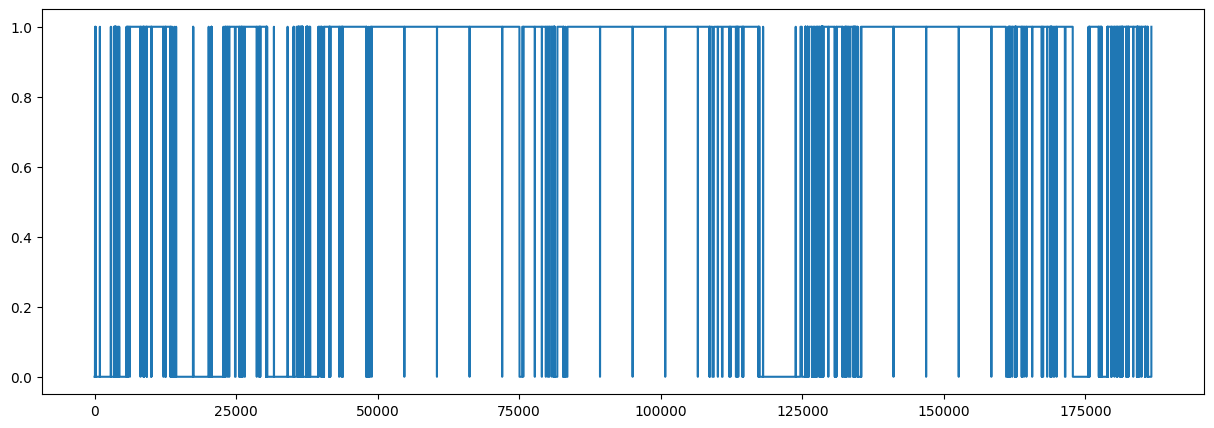

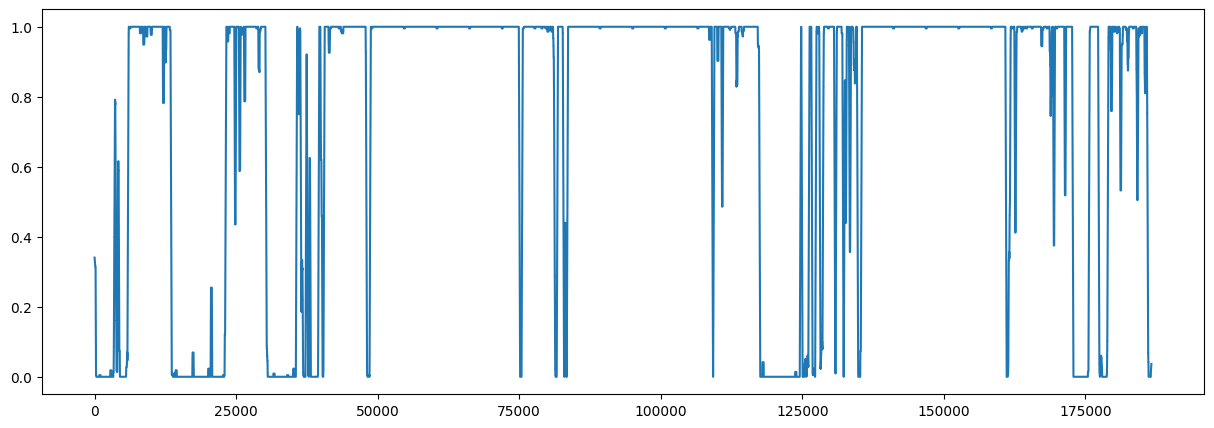

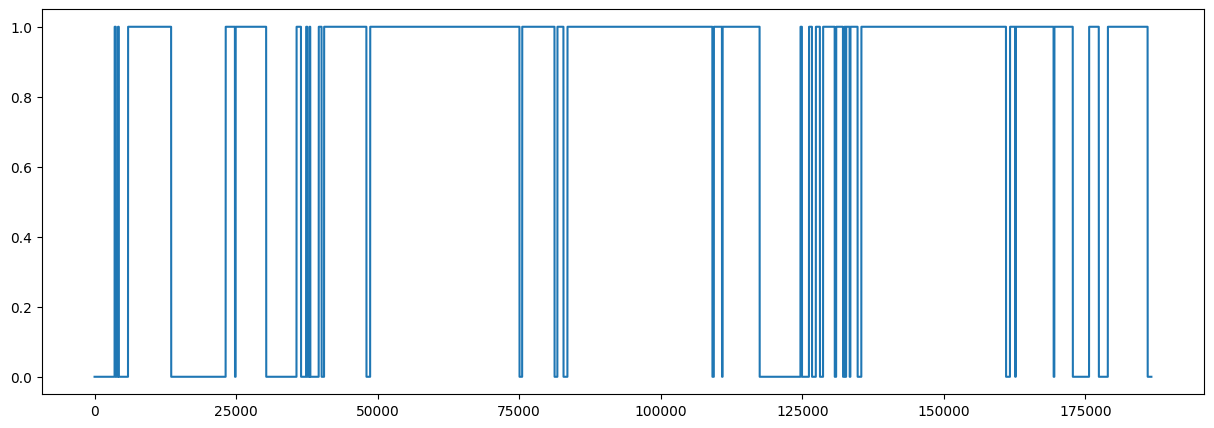

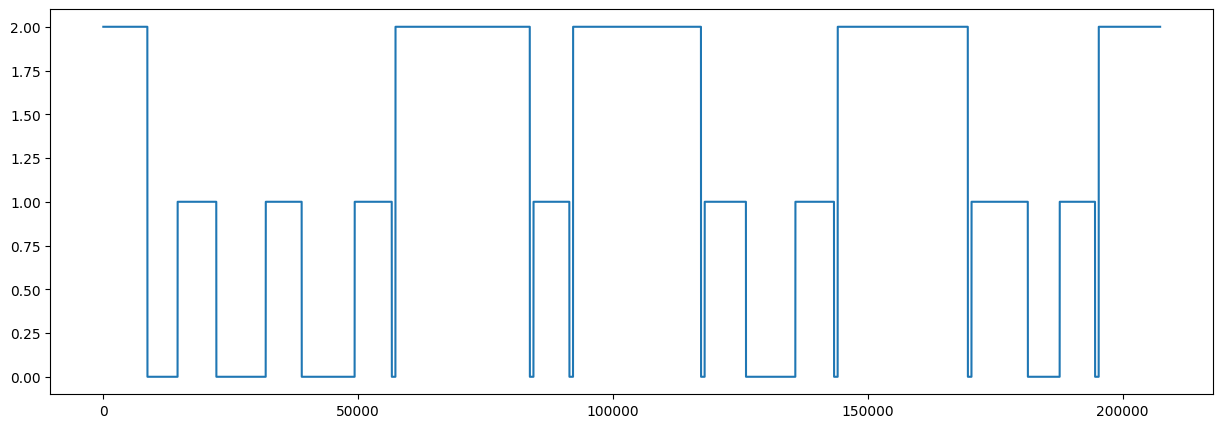

In [302]:
savgol_filter_events = np.expand_dims(savgol_filter(events[:,0],window_length=17280//80,polyorder=1),axis = -1)
plot_all(events)
plot_all(savgol_filter_events)
plot_all(savgol_filter_events > 0.5)
plot_all(np.expand_dims(train_series.series[train_serie_id].slices[:,-1],axis = -1))

[((0, 207359), '03d92c9f6f8a'),
 ((207360, 656639), '04f547b8017d'),
 ((656640, 794879), '05e1944c3818'),
 ((794880, 1192319), '1b92be89db4c'),
 ((1192320, 1330559), '1c7c0bad1263'),
 ((1330560, 1572479), '1d4569cbac0f'),
 ((1572480, 1727999), '1e6717d93c1d'),
 ((1728000, 2073599), '1f96b9668bdf'),
 ((2073600, 2522879), '2b0a1fa8eba8'),
 ((2522880, 3075839), '2b8d87addea9'),
 ((3075840, 3283199), '2cd2340ca14d'),
 ((3283200, 3525119), '2e9ced2c7976'),
 ((3525120, 3870719), '2f7504d0f426'),
 ((3870720, 4268159), '2fbbee1a38e3'),
 ((4268160, 4337279), '3a9a9dc2cbd9'),
 ((4337280, 4907519), '3aceb17ef7bd'),
 ((4907520, 5287679), '3be1545083b7'),
 ((5287680, 5425919), '3be2f86c3e45'),
 ((5425920, 5719679), '3c336d6ba566'),
 ((5719680, 6117119), '3d53bfea61d6'),
 ((6117120, 6376319), '3df0da2e5966'),
 ((6376320, 6894719), '4a31811f3558'),
 ((6894720, 7309439), '4ab54be1a403'),
 ((7309440, 7655039), '4ac356361be9'),
 ((7655040, 8017919), '4b45c36f8f5a'),
 ((8017920, 8380799), '4feda0596965')

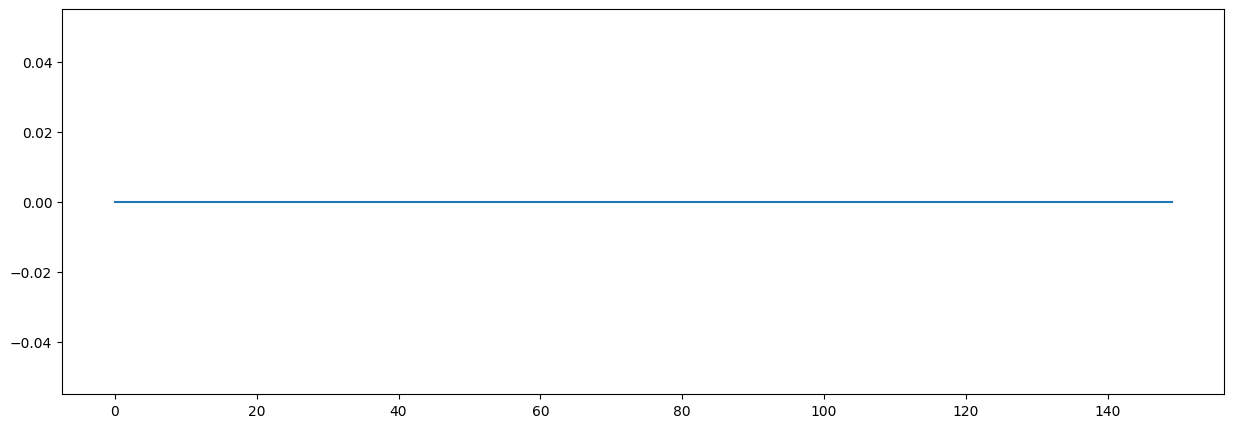

In [170]:
serie_id = "038441c925bb"        
valid_range = test_series.series["038441c925bb"].valid_ranges_padding
y_pred_test = unet.predict(windowed_train_ds)
raw_prediction = y_pred_test[:][:3]


traun==

try:
    del test_prediction
except:
    pass

test_prediction = Prediction(serie_id,valid_range,raw_prediction)
test_prediction.separate()
events,scores = test_prediction.create_events(loss_weights)

In [101]:
scores_weights = list(loss_weights.values())
all_predictions_no = len(test_prediction.raw_prediction)

for i in range(all_predictions_no+1):
    
    # get auxiliary predicitons
    if i  < all_predictions_no and i == 0:
        outputs = test_prediction.auxiliary_predictions[i].shape[-1]
        outputs_weights = [i/(outputs-1) for i in range(outputs)]

        auxiliary_events = np.argmax(test_prediction.auxiliary_predictions[i],axis = -1,keepdims=True)
        mc_weight = lambda x : outputs_weights[x]
        # multi_class_weight = np.apply_along_axis(lambda x : outputs_weights[x],)
        multi_class_weight = mc_weight(auxiliary_events)
        wakeup_scores = np.multiply(test_prediction.auxiliary_predictions[i]  *scores_weights[i] ,multi_class_weight)
        wakeup_scores = np.where (auxiliary_events > 0, wakeup_scores[auxiliary_events], 0.0)         # get main prediction 
    if i  < all_predictions_no and i == 1:
        outputs = test_prediction.auxiliary_predictions[i].shape[-1]
        outputs_weights = [i/(outputs-1) for i in range(outputs)]

        onset_events = np.argmax(test_prediction.auxiliary_predictions[i],axis = -1,keepdims=True)
        mc_weight = lambda x : outputs_weights[x]
        # multi_class_weight = np.apply_along_axis(lambda x : outputs_weights[x],)
        multi_class_weight = mc_weight(onset_events)
        onset_scores = np.multiply(test_prediction.auxiliary_predictions[i]  *scores_weights[i] ,multi_class_weight)
        onset_scores = np.where (onset_events > 0, onset_scores[onset_events], 0.0)
    else: 
        scores = np.zeros_like(test_prediction.main_prediction)
        scores[:,0] = (test_prediction.main_prediction[:,0] + wakeup_score)/(1.0 + scores_weights[0])
        scores[:,1] = (test_prediction.main_prediction[:,1] + onset_score)/(1.0 + scores_weights[1])
        scores  = scores[:,0:2] # only wakeup and onset to consider
        events = np.argmax(test_prediction.main_prediction,axis = -1,keepdims=True)
        scores = np.max(test_prediction.main_prediction,axis=-1,keepdims=True) 


scores

TypeError: only integer scalar arrays can be converted to a scalar index

In [123]:
np.eye(np.asarray(auxiliary_events[:,0],np.int))

C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_13860\3114651744.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.eye(np.asarray(wakeup_events[:,0],np.int))


TypeError: only integer scalar arrays can be converted to a scalar index

In [120]:
np.cast(auxiliary_events[:,0],np.int)

C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_13860\1053808001.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.cast(wakeup_events[:,0],np.int)


TypeError: '_typedict' object is not callable

In [138]:
auxiliary_events

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [136]:
ow = np.expand_dims(np.array(outputs_weights),axis = -1)

In [144]:
auxiliary_events = np.argmax(test_prediction.auxiliary_predictions[0],axis = -1,keepdims=True)
ow = np.expand_dims(np.array(outputs_weights),axis = -1)
eye = np.zeros((auxiliary_events.shape[0],10))
eye[np.arange(auxiliary_events.shape[0]),auxiliary_events[:,0]] = 1
mc = np.where (auxiliary_events > 0, np.dot(eye,ow), 0)
mc[15:40]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [148]:
onset_events = np.argmax(test_prediction.auxiliary_predictions[1][:,1:],axis = -1,keepdims=True)
ow = np.expand_dims(np.array(outputs_weights),axis = -1)
eye = np.zeros((onset_events.shape[0],10))
eye[np.arange(onset_events.shape[0]),onset_events[:,0]] = 1
mc = np.where (onset_events > 0, np.dot(eye,ow), 0)
mc[15:40]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

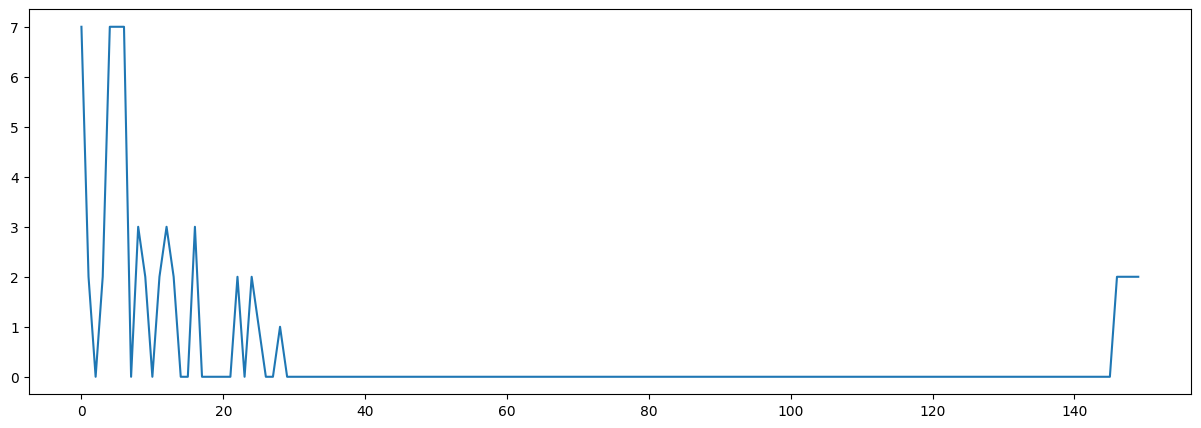

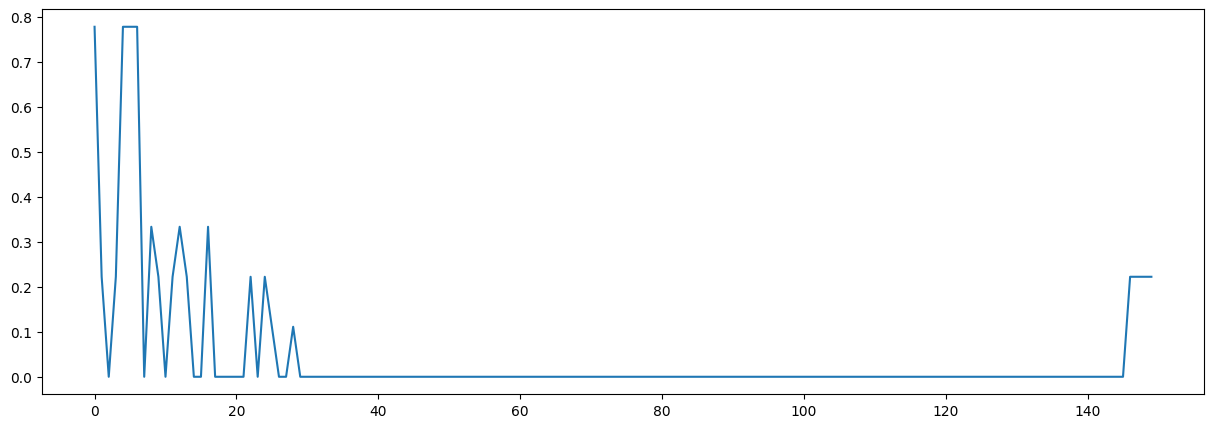

In [165]:
onset_events = np.argmax(test_prediction.auxiliary_predictions[1][:,1:],axis = -1,keepdims=True)
plot_all(onset_events)
ow = np.expand_dims(np.array(outputs_weights),axis = -1)
eye = np.zeros((onset_events.shape[0],len(outputs_weights)))
eye[np.arange(onset_events.shape[0]),onset_events[:,0]] = 1
mc = np.where (onset_events > 0, np.dot(eye,ow), 0)
plot_all(mc)

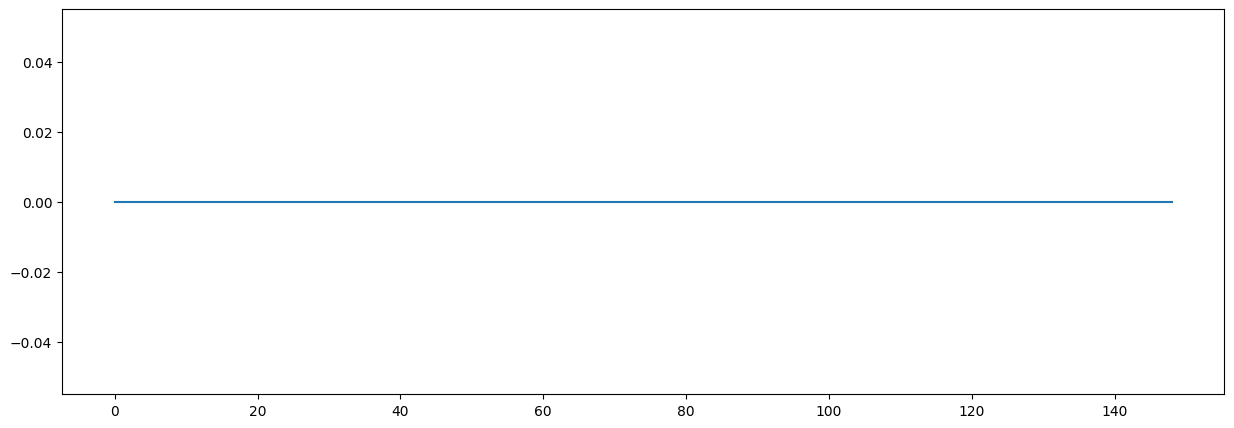

In [150]:
plot_all(np.argmax(test_prediction.auxiliary_predictions[1][1:],axis = -1,keepdims=True))

(150, 10)
(150, 10)
(150, 3)
[[11160, 5971]]


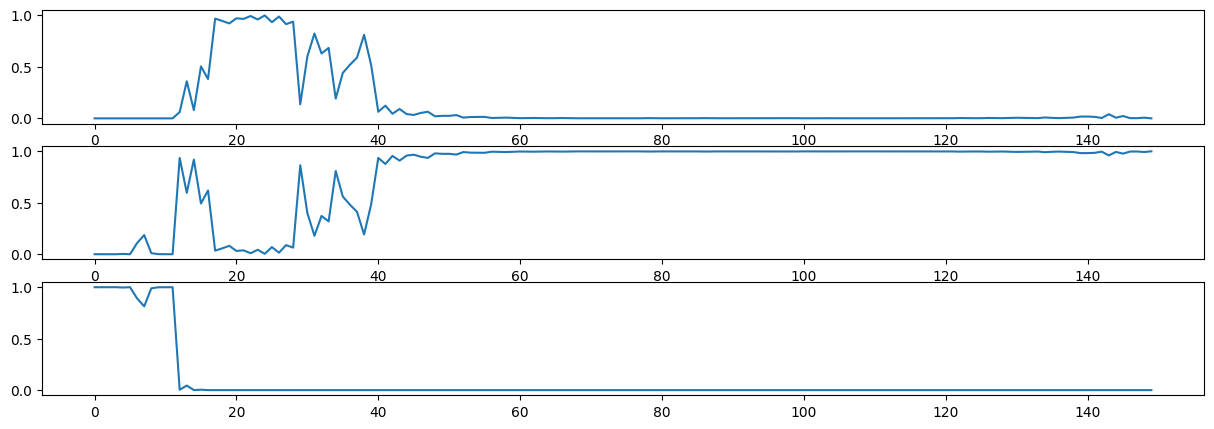

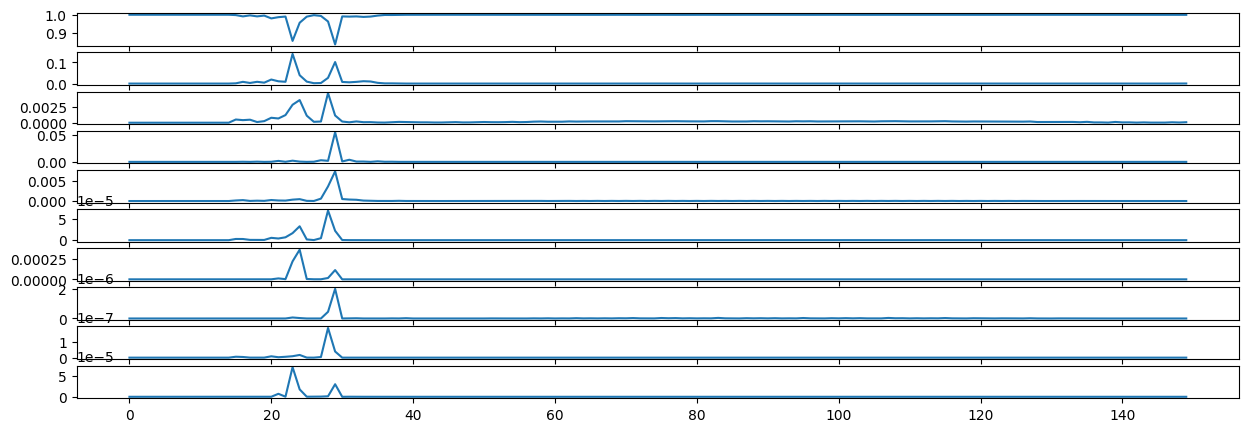

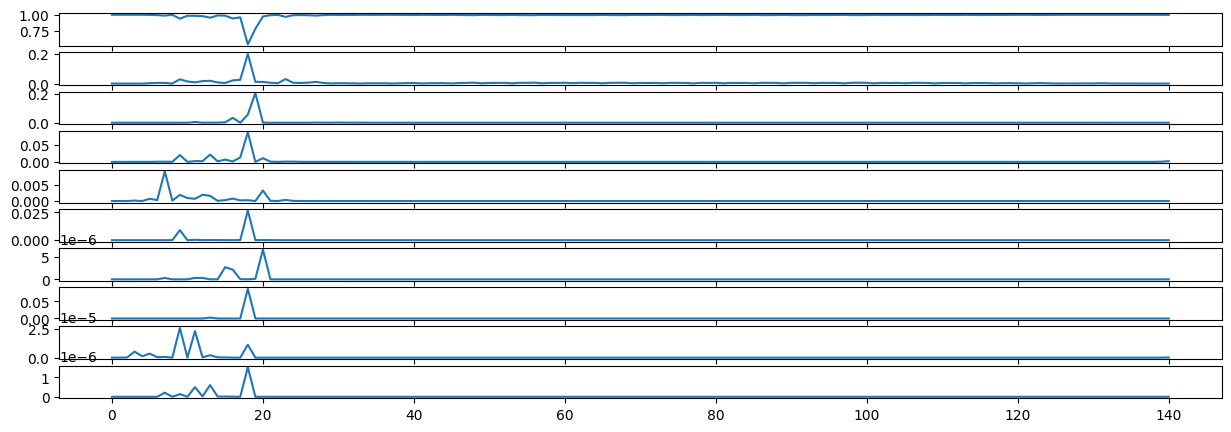

In [162]:

print(test_prediction.auxiliary_predictions[0].shape)
print(test_prediction.auxiliary_predictions[1].shape)
print(test_prediction.main_prediction.shape)
print(valid_range)
plot_all(test_prediction.main_prediction)
plot_all(test_prediction.auxiliary_predictions[0])
plot_all(test_prediction.auxiliary_predictions[1][:])

In [45]:


decode_list = {

    0 : "wakeup",
    1 : "onset",
    2 : "unknown"

}
class Prediction():
    def __init__(self,  serie_id, valid_range,raw_prediction):
        self.serie_id = serie_id
        self.valid_range = valid_range
        self.raw_prediction = raw_prediction
        self.main_prediction = None
        self.auxiliary_predictions = []
    def separate(self):
        for stop,start in valid_range:
            all_predictions_no = len(self.raw_prediction)
            for i in range(all_predictions_no+1):
                outputs = self.raw_prediction[i].shape[-1]
                prediction = self.raw_prediction[i].reshape(-1,outputs)[start:stop]
                # get auxiliary predicitons
                if i  < all_predictions_no:
                    self.auxiliary_predictions.append(prediction)
                 # get main prediction 
                else: 
                    self.main_prediction = prediction
    

    def create_events(self, loss_weights,only_top_score = True , generate_dummies = False):
        # create step seg list
        #         - events - segmentation mask
        #         -  score   - predicited vaues for chosen event

        def detectChange(last_val,current_val):
            if last_val == -1 or current_val == -1:
                return False
            


        scores_weights = list(loss_weights.values())
        all_predictions_no = len(self.raw_prediction)

            for i in range(all_predictions_no+1):
                
                # get auxiliary predicitons
                if i  < all_predictions_no and i == 0:
                    outputs = self.auxiliary_predictions[i].shape[-1]
                    outputs_weights = [i/(outputs-1) for i in range(outputs)]

                    wakeup_events = np.argmax(self.auxiliary_predictions[i],axis = -1,keepdims=True)
                    mc_weight = lambda x : outputs_weights[x]
                    # multi_class_weight = np.apply_along_axis(lambda x : outputs_weights[x],)
                    multi_class_weight = mc_weight(wakeup_events)
                    wakeup_events = np.where (events >0 , 0, 2)
                    wakeup_scores = np.multiply(np.max(self.auxiliary_predictions[i],axis=-1,keepdims=True)  *scores_weights[i] ,multi_class_weight)
                 # get main prediction 
                if i  < all_predictions_no and i == 1:
                    outputs = self.auxiliary_predictions[i].shape[-1]
                    outputs_weights = [i/(outputs-1) for i in range(outputs)]

                    onset_events = np.argmax(self.auxiliary_predictions[i],axis = -1,keepdims=True)
                    mc_weight = lambda x : outputs_weights[x]
                    # multi_class_weight = np.apply_along_axis(lambda x : outputs_weights[x],)
                    multi_class_weight = mc_weight(onset_events)
                    onset_scores = np.multiply(self.auxiliary_predictions[i]  *scores_weights[i] ,multi_class_weight)
                    onset_scores = np.where (onset_events > 0, onset_scores[onset_events], 0.0)
                else: 
                    scores = np.zeros_like(self.main_prediction)
                    scores[:,0] = (self.main_prediction[:,0] + self.wakeup_score)/(1.0 + scores_weights[0])
                    scores[:,1] = (self.main_prediction[:,1] + self.onset_score)/(1.0 + scores_weights[1])
                    scores  = scores[:,0:2] # only wakeup and onset to consider
                    events = np.argmax(self.main_prediction,axis = -1,keepdims=True)
                    scores = np.max(self.main_prediction,axis=-1,keepdims=True) 
    
        events = np.argmax(self.main_prediction,axis = -1,keepdims=True)
        scores = np.max(self.main_prediction,axis=-1,keepdims=True)      
        # round to decimals places
        scores = np.round(scores,decimals=1)        

        step = -1
        for slices_num in range(events.shape[0]):
            slice = events[slices_num]
            score = scores[slices_num]
            # flags for filtering only one event per slice
            event_detected = False
            highest_score,event_score = -1.0 , -1.0
            for i in range(events.shape[1]):
                step+=1
                event_val = slice[i][0]
                event_score = score[i][0]

                if i == 0:
                    # do not detect anything during first step
                    continue
                elif not detectChange(slice[i-1][0],event_val):
                    continue
                if only_top_score :
                    event_detected = True
                    # if detected event in slice is not the first or below the highest - continue 
                    if event_score <highest_score and highest_score != -1.0:
                        continue
                    index = step 
                    event = event_val
                    highest_score = event_score
                
                else:
                    print(serie.serie_id,step)
                    df_events.loc[len(df_events.index)] = [serie.serie_id,step,event_val,event_score]                

            
            if event_detected:
                print(serie.serie_id,step)
                df_events.loc[len(df_events.index)] = [serie.serie_id,index,event,highest_score]


        # if nothing was detected: 
        if len(df_events.index) == 0 and generate_dummies:
            df_events.loc[len(df_events.index)] = [serie.serie_id,0,1,0.0]
            df_events.loc[len(df_events.index)] = [serie.serie_id,0,2,0.0]

        # decode events 
        df_events = serie.decode_events(df_events)
        # save as serie events 
        return df_events #,y_pred_unpadded




    



    


class Predictions():
    def __init__(self, slices_ids,predictions,window_size, ) -> None:
        
        #common
        self.predictions  = {}
        self.slices_ids = slices_ids
        # unet predictions
        self.raw_predictions = predictions 
        # Seri
        # ds
        self.window_size = window_size 
    def extract_predictions(self, series : Series):
        
        for slice_range, slice_id in self.slices_ids:
            if slice_id not in series.series.keys():
                raise ValueError("wrong series object, id {slice_id} did not find")
            valid_range = series.series[slice_id].valid_ranges_padding
            window_start = slice_range[0]//self.window_size
            window_stop =  (slice_range[1]- slice_range[0] + 1 )//self.window_size
            self.predictions[slice_id]  = Prediction(valid_range,self.window_size,self.raw_predictions[:][window_start:window_stop])
                                                     




(9, 5760, 3)

In [38]:
ds.serie_length

AttributeError: 'Dataset' object has no attribute 'serie_length'

In [13]:
y_pred_test_argmax = None
y_pred_test_argmax = np.argmax(y_pred_test[0][:3,:,:].reshape(-1,10),axis = -1,keepdims = True)


In [67]:
y_pred_test_argmax.shape

(17280,)

In [72]:
np.max(y_pred_test[0])

1.0

In [71]:
max(y_pred_test_argmax) == np.max(y_pred_test[0])

False

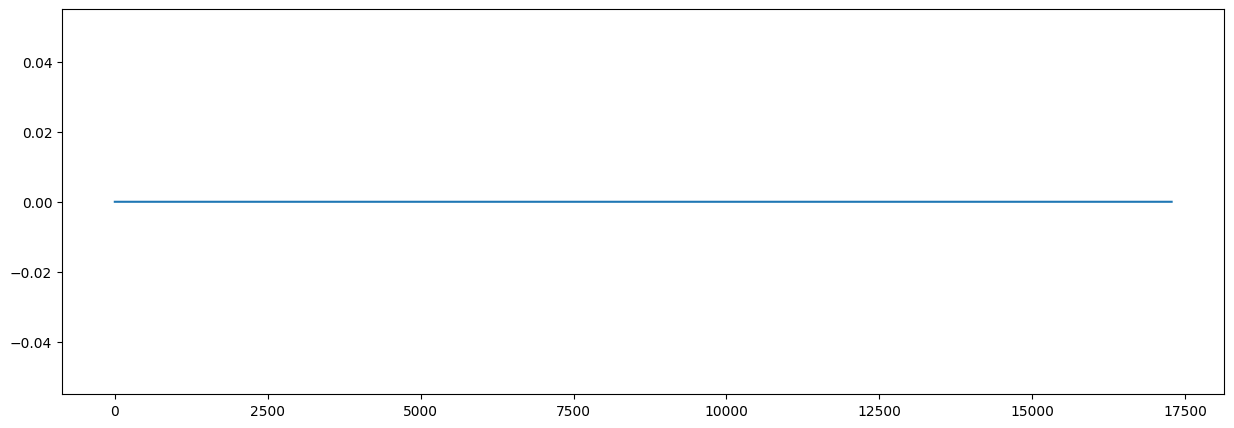

In [14]:
plot_all(y_pred_test_argmax)

In [39]:
ds.test_slices_ids

[((0, 17279), '038441c925bb'),
 ((17280, 34559), '03d92c9f6f8a'),
 ((34560, 51839), '0402a003dae9')]

In [19]:
pred_038441c925bb = y_pred_test[2][:3,:,:].reshape(-1,3)

In [16]:
pred_038441c925bb[:2]

array([[9.9748307e-01, 5.5486773e-04, 1.2629399e-03, 1.8784253e-07,
        6.4125820e-04, 7.2121520e-06, 5.0248662e-05, 5.8004679e-10,
        6.0854738e-10, 6.2655062e-08],
       [9.9965477e-01, 3.0019041e-04, 4.4086162e-05, 3.2398244e-09,
        7.0967906e-07, 1.7302478e-09, 2.5662558e-07, 3.9445199e-16,
        5.7226304e-15, 2.6464661e-10]], dtype=float32)

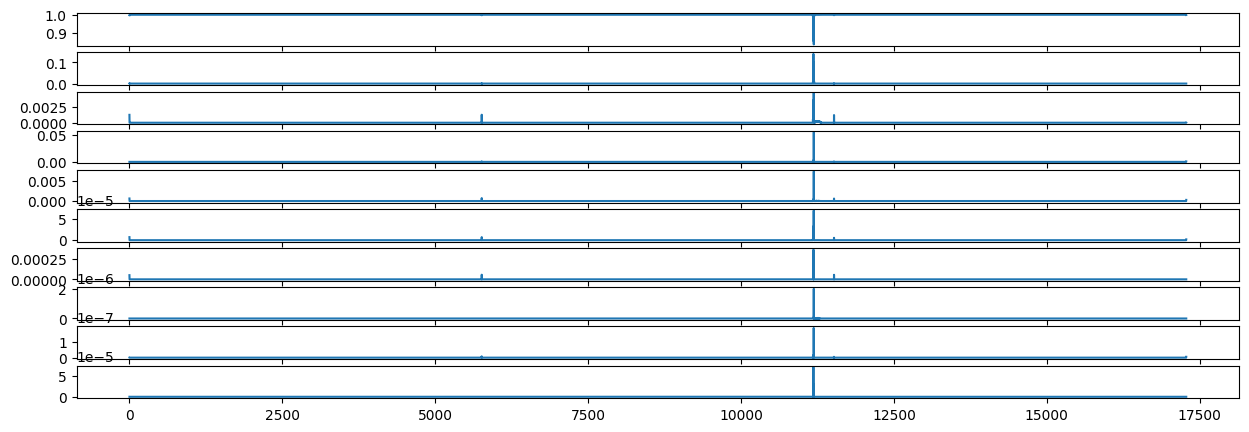

In [29]:
plot_all(y_pred_test[0][:3,:,:].reshape(-1,10))

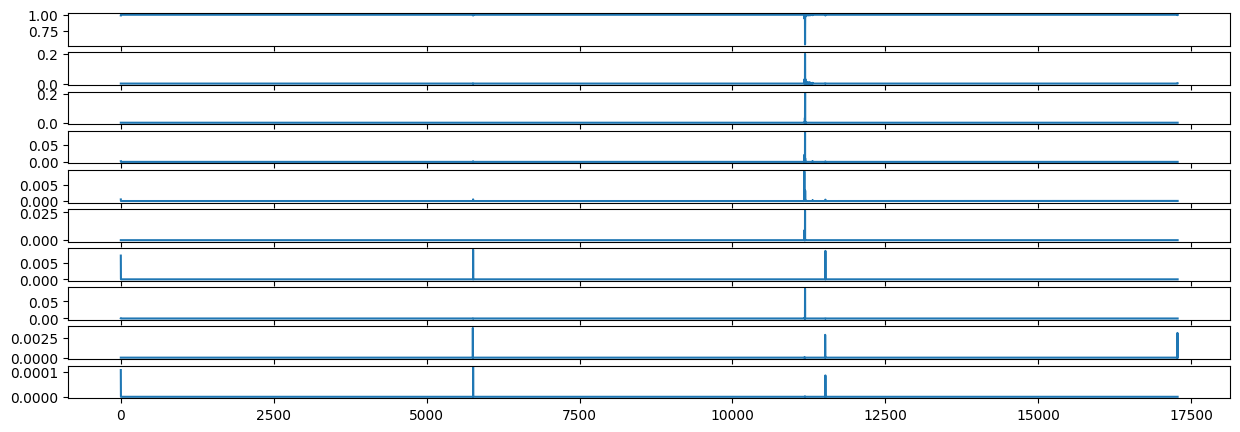

In [24]:
plot_all(y_pred_test[1][:3,:,:].reshape(-1,10))

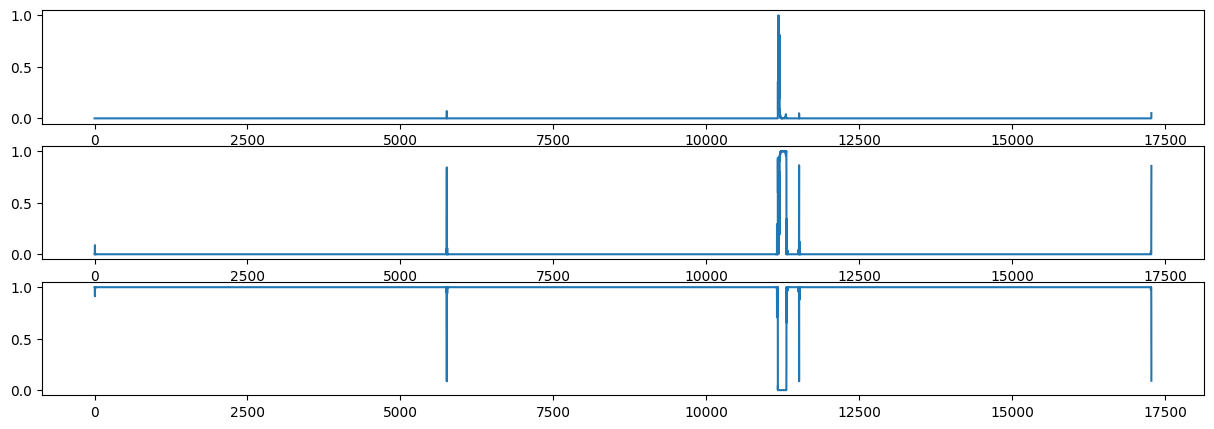

In [20]:
plot_all(pred_038441c925bb)

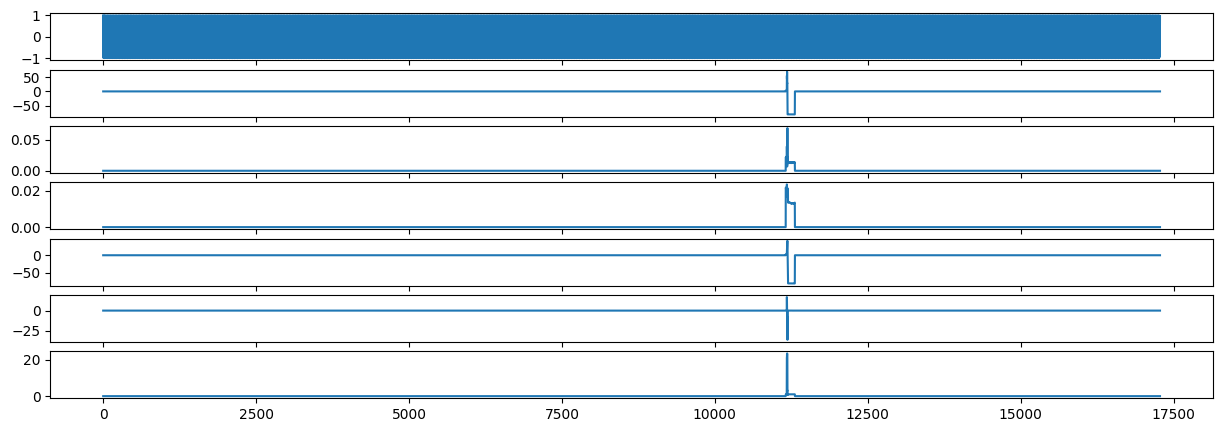

In [28]:
test_038441c925bb = None 
i = 0
for window in windowed_test_ds:
    reshaped = window.numpy()[:3,:,:].reshape(-1,7)
    
    break

test_038441c925bb = reshaped
plot_all(test_038441c925bb)

In [ ]:
# # Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "model/weights/cp-{epoch:04d}.ckpt"
# # save weights 
# unet.save_weights(checkpoint_path.format(epoch=100))
# #save model
# models_path = "model/saved_models/unet_{version}_{now}"
# unet.save(models_path.format(version = "v1", now = str(datetime.now().date())))

In [ ]:
# # Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "model/weights/cp-{epoch:04d}.ckpt"

# # Loads the weights
# unet.load_weights(checkpoint_path.format(epoch =100))

# # Re-evaluate the model
# # loss, acc = unet.evaluate(test_images, test_labels, verbose=2)
# # print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
# def create_events(y_pred :np.array,serie):
#     """create df_events 
#     input:
#     y_pred - score  (predicited vaues )"""
#     def detectChange(last_val,current_val):
#         if last_val == -1 or current_val == -1:
#             return False

#         return last_val !=current_val

#     # create empty dataframe
#     df_events = pd.DataFrame(columns=["series_id","step","event","score"])
#     # unpad y_pred
#     if serie.slice_pads is None:
#         y_pred_unpadded = y_pred
#     else:
#         y_pred_unpadded = serie._unpad(y_pred,serie.slice_pads)
#     # create step seg list
#     #         - events - segmentation mask
#     #         -  score   - predicited vaues for chosen event
#     events = np.argmax(y_pred_unpadded,axis = -1,keepdims=True)
#     score = np.max(y_pred_unpadded,axis=-1,keepdims=True)      
#     for slice_num in range(events.shape[0]):
#         for i in range(events.shape[-2]):
#             event_val = events[slice_num,i][0]
#             event_score = score[slice_num,i][0]
#             if i == 0:
#                 # do not detect anything during first step
#                 continue
#             elif not detectChange(events[slice_num,i-1],event_val):
#                 continue

#             df_events.loc[len(df_events.index)] = [serie.serie_id,i,event_val,event_score]
    
#     # decode events 
#     print(df_events)
#     df_events = serie.decode_events(df_events)
#     # save as serie events 
#     serie_events = df_events

#     return serie_events 

In [ ]:
# def predict(model,test_serie):
#     x = test_serie.slices
#     y_pred = model.predict(x)
#     serie_events = create_events(y_pred,test_serie)   
#     return serie_events

# test_series_pred = {}
# for serie_id, test_serie in test_series.series.items():
#     serie_events = predict(unet,test_serie)
#     print(serie_events)


1/1 [==============================] - 0s 21ms/step


      series_id  step  event      score
0  038441c925bb     5      2  29.746996
1  038441c925bb    17      1  46.573971
2  038441c925bb    22      2  33.335999
3  038441c925bb    25      1  47.931240
      series_id  step   event      score
0  038441c925bb     5   onset  29.746996
1  038441c925bb    17  wakeup  46.573971
2  038441c925bb    22   onset  33.335999
3  038441c925bb    25  wakeup  47.931240
1/1 [==============================] - 0s 17ms/step
Empty DataFrame
Columns: [series_id, step, event, score]
Index: []
Empty DataFrame
Columns: [series_id, step, event, score]
Index: []


In [ ]:
# from matplotlib import pyplot as plt
# plt.plot(history.history["accuracy"])

NameError: name 'history' is not defined

In [ ]:
# def accuracy(real,pred):
#     comp = real == pred
#     return np.sum(comp)/(comp.shape[0]*comp.shape[1])


# y_train_pred = unet.predict(X_train)
# print("train accuracy : " + str(accuracy(y_train,y_train_pred)))


# y_test_pred = unet.predict(X_test)
# print("test accuracy : " +  str(accuracy(y_test,y_test_pred)))

In [ ]:
# from IPython.display import FileLink
# import pandas as pd

# # import os
# # os.chdir(r'kaggle/working')'
# filename = 'train_' +'.csv'
# pd.DataFrame(test_mask).to_csv(filename)

# FileLink(filename)



ValueError: Must pass 2-d input. shape=(51, 8640, 3)